100%|██████████| 100000/100000 [00:01<00:00, 78758.23it/s]


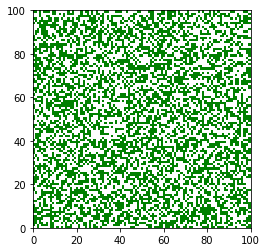

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from tqdm import tqdm
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation

### These functions are copied from the Notebook
### See animation code at bottom

cmap = ListedColormap(['white', 'green'])

# Uniform Lattice creation
def normal_lattice(N, M, value=0):
    '''
    This function returns an N (rows) x M (columns) lattice with identical values value
    '''
    return np.full((N, M), value)

# Random Lattice creation
def random_lattice(N, M):
    '''
    This function returns an N (rows) x M (columns) lattice with randomized spin values 0 or 1
    '''
    return rng.choice((-1, 1), (N, M))

# plot a lattice
def plot_lattice(lattice, ax=None):
    """
    Create a visualization of a lattice 
    """
    if ax is None:
        ax = plt.gca()
    
    edgecolor = 'black' if max(lattice.shape) < 25 else None
    im = ax.pcolormesh(lattice, cmap=cmap, edgecolor=edgecolor, vmax=1, vmin=-1)
    ax.set_aspect('equal')
    return im

def random_select(lattice):
    """
    Randomly choose a position (i,j) in the lattice
    """
    N, M = lattice.shape
    i = rng.randint(0, N)
    j = rng.randint(0, M)
    
    return (i, j)

def flip_spin(lattice, i, j):
    """
    Flip the spin of lattice site (i,j) and return its new value
    """
    lattice[i,j] *= -1
    return lattice[i,j]

def combined_spin_state(lattice, i, j):
    """
    Determine the combined spin state due to nearest neighbors around lattice site (i,j)
    Periodic BC are used for lattice sites at the edge
    """
    N, M = lattice.shape
    
    total = lattice[(i+1)%N, j]
    total += lattice[(i-1)%N, j]
    total += lattice[i, (j+1)%M]
    total += lattice[i, (j-1)%M]
    
    return total

def local_energy(lattice, i, j, J, H):
    """
    Determine the local energy of the lattice at site (i,j) with coupling
    coefficient J and external field strength H
    """
    combined = combined_spin_state(lattice, i, j)
    energy = (-J*combined - H)*lattice[i,j]
    return energy

def total_energy_python(lattice, J, H):
    """
    Determine the total energy of the lattice with coupling
    coefficient J and external field strength H
    """
    N, M = lattice.shape
    
    energy = 0
    for i in range(N):
        for j in range(M):
            energy += local_energy(lattice, i, j, J, H)
            
    return energy

def energy_density_numpy(lattice, J, H):
    """
    Determine the energy density of the lattice with coupling
    coefficient J and external field strength H
    """
    N, M = lattice.shape
    
    combined = np.roll(lattice, +1, axis=0) \
             + np.roll(lattice, -1, axis=0) \
             + np.roll(lattice, +1, axis=1) \
             + np.roll(lattice, -1, axis=1)     
    energy_density = (-J*combined - H)*lattice
            
    return energy_density

def total_energy_numpy(energy_density):
    """
    Determine the total energy of the lattice by summing
    """
    return np.sum(energy_density)

def energy_variance(energy_density, T=1.):
    """
    Determine the variance of the energy of the lattice.
    Normalize by the temperature if specified.
    """
    return np.var(energy_density/(T**2))

def magnetization(lattice):
    return np.sum(lattice)

def magnetization_per_spin(lattice):
    M = magnetization(lattice)
    total = np.prod(lattice.shape)
    
    return M/total

def update_lattice(lattice, T, J, H):
    i, j = random_select(lattice)

    E = local_energy(lattice, i, j, J, H)
    delta_energy = -2*E
    
    if delta_energy < 0:
        flip_spin(lattice, i, j)
    else:
        r = rng.uniform(0, 1)
        boltzman = np.exp(-delta_energy/T)
        if r < boltzman:
            flip_spin(lattice, i, j)

### setup variables
N, M = 100, 100
J, H = 1, 0
T = 1.5

store_every = 100
Nsteps = 100000

history = []
lattice = random_lattice(N, M)

### run many iterations, storing the lattice in history
for t in tqdm(range(Nsteps)):
    update_lattice(lattice, T, J, H) 

    if t % store_every == 0:
        history.append(lattice.copy())

history = np.asarray(history)

### Create an animation
fig, ax = plt.subplots()
im = plot_lattice(history[0], ax=ax)

def updatefig(frame):
    dataImg = history[frame, :-1,:-1]
    im.set_array(np.ravel(dataImg.T))

    return [im]

anim = animation.FuncAnimation(fig, updatefig, np.arange(0, len(history)), repeat=True, interval=30)

plt.show()
